In [36]:
from pathlib import Path
from IPython.display import display

import numpy as np
import pandas as pd

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.pyplot as plt

import spotipy
import lib_spotify_app.api_adapter as api_adapter

pd.set_option('max_columns', None)

In [2]:
df = pd.read_csv(Path(r'private/data.csv'), sep='\t')

 Let's retrieve the most useful column for our analysis like:
 * related to music features
 * to classify it (name, etc...)
 * release date (could be related to a specific era)

In [3]:
col = [
    'added_at',
    'album.id',
    'album.images.0.height',
    'album.images.0.url',
    'album.images.0.width',
    'album.name',
    'album.release_date',
    'album.release_date_precision',
    'artists.id',
    'artists.name',
    'duration_min',
    'id',
    'external_urls.spotify',
    'name',
    'popularity',
    'preview_url',
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'time_signature'
]

feat = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
]

Let's have a general view of the kind of music I listen to

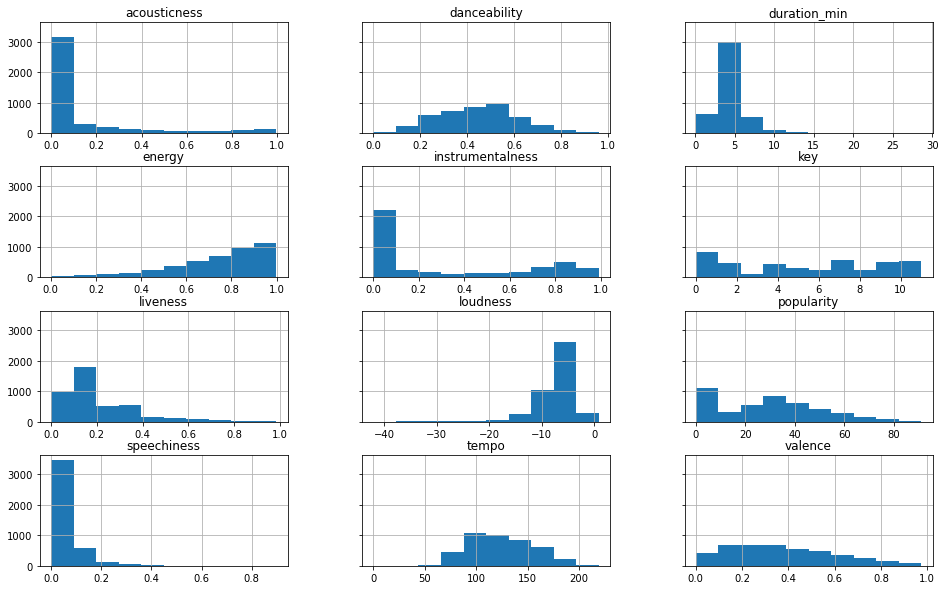

In [4]:
df[feat+['duration_min', 'popularity']].hist(sharey=True, figsize=(16, 10));

There is more 10 audio features given by Spotify, to view our songs in 1 view, I will apply a dimensionnality reduction algorithm to project in a 2D plane.
After that I will cluster on this plane.
Then we can see if the clustering make sense...

UMAP(metric='mahalanobis', n_neighbors=16, random_state=0, verbose=1)
Construct fuzzy simplicial set
Mon Jun 29 23:19:53 2020 Finding Nearest Neighbors
Mon Jun 29 23:19:53 2020 Building RP forest with 8 trees
Mon Jun 29 23:19:54 2020 NN descent for 12 iterations
	 0  /  12
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	 5  /  12
	 6  /  12
	 7  /  12
	 8  /  12
	 9  /  12
Mon Jun 29 23:19:55 2020 Finished Nearest Neighbor Search
Mon Jun 29 23:19:55 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provi

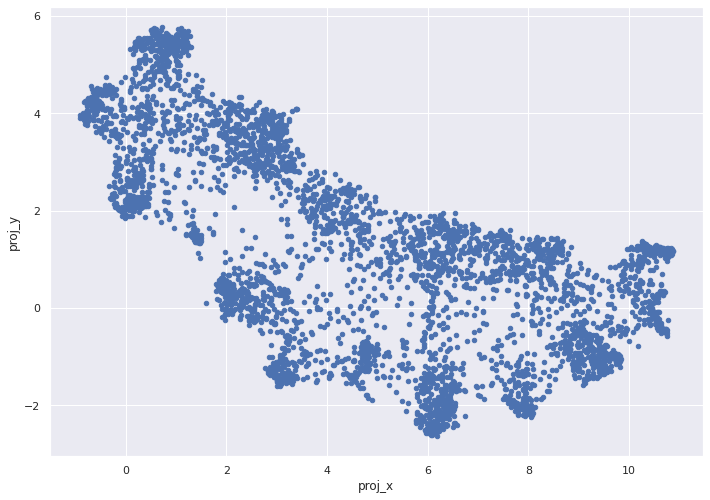

In [37]:
from umap import UMAP
mdl_proj = UMAP(
    n_neighbors=16,
    metric='mahalanobis',
    verbose=1,
    random_state=0
)

df[['proj_x', 'proj_y']] = pd.DataFrame(mdl_proj.fit_transform(df[feat]))
df[['proj_x', 'proj_y']].plot(kind='scatter', x='proj_x', y='proj_y');

Let's see a bit where the supergenre calculated previously are in this projection

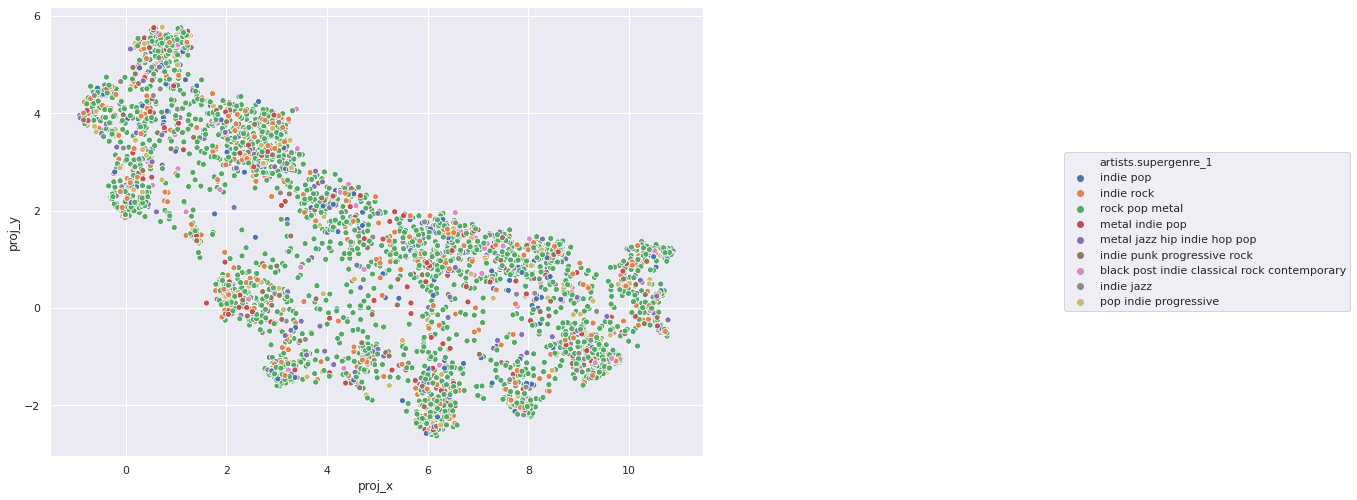

In [38]:
g = sns.scatterplot(data=df, x='proj_x', y='proj_y', hue='artists.supergenre_1', legend='full');
g.legend(loc='center right', bbox_to_anchor=(2, 0.5), ncol=1);

This is expected, and even as intended, I am not focusing on a music genre, but on a music audio, for example a group of "sad" songs of multilple genres...

I fine-tuned HDBSCAN with the min_cluster_size and let min_samples be found
min_cluster_size should be similar to an album size (10-20) or a playlist size (50-100)
the size of 16 seems the magic (other size around does not give similar clusters number and size)

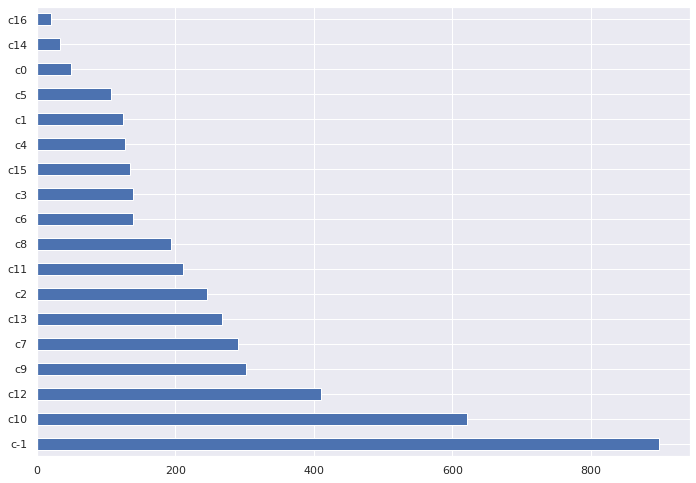

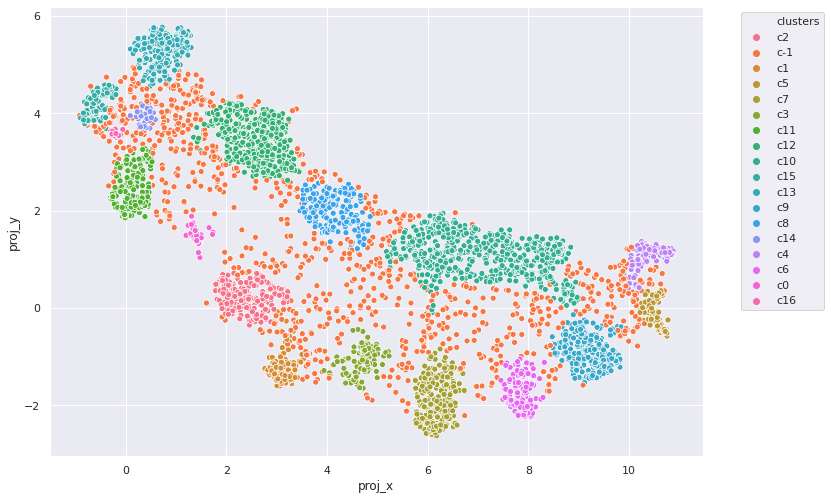

In [40]:
from hdbscan import HDBSCAN

df['clusters'] = HDBSCAN(min_cluster_size=20, min_samples=20)\
                    .fit_predict(df[['proj_x', 'proj_y']], min)
df['clusters'] = df['clusters'].map(lambda x: f'c{x}')

plt.figure()
df['clusters'].value_counts().plot(kind='barh');

plt.figure()
sns.scatterplot('proj_x', 'proj_y', data=df, hue='clusters', cmap=sns.color_palette('husl'));
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

Let's see if those clusters make sense by printing each 10 most popular songs

In [48]:
# count of most popular songs to analyse
top_n = 3

In [49]:
col = feat+[
    'clusters',
    'proj_x',
    'proj_y',
    'popularity',
    'duration_min',
    'name',
    'artists.name',
    'album.name',
    'artists.genres',
    'artists.supergenres',
    'artists.supergenre_1',
    'external_urls.spotify',
    'preview_url'
]

df_top = df[col].groupby('clusters').apply(
    lambda x: x.sort_values('popularity', ascending=False).head(top_n)
)

df_top.sample(5)

,,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,clusters,proj_x,proj_y,popularity,duration_min,name,artists.name,album.name,artists.genres,artists.supergenres,artists.supergenre_1,external_urls.spotify,preview_url
clusters,,,,,,,,,,,,,,,,,,,,,,,,
c-1,3284,0.733,0.710,5,-5.849,0.0292,0.14500,0.115000,0.0956,0.965,127.975,c-1,3.692611,-0.525591,83,3.993333,Pumped Up Kicks,['Foster The People'],Torches,"['indie pop', 'modern alternative rock', 'mode...",['rock pop metal'],rock pop metal,https://open.spotify.com/track/7w87IxuO7BDcJ3Y...,https://p.scdn.co/mp3-preview/db83e69f4ef8a49f...
c4,4173,0.813,0.601,11,-7.552,0.1160,0.18900,0.000200,0.4260,0.855,118.981,c4,10.336098,1.104267,77,2.957983,Needs,['Verzache'],Needs,['lo-fi beats'],['rock pop metal'],rock pop metal,https://open.spotify.com/track/0WKmVAD4VWk5EdT...,https://p.scdn.co/mp3-preview/99ab2adb661e10c3...
c3,2679,0.384,0.765,6,-4.463,0.0579,0.64600,0.003520,0.5220,0.567,129.903,c3,4.542126,-1.072750,79,4.203833,Sunflower,['Rex Orange County'],Sunflower,"['bedroom pop', 'indie r&b', 'pop']",['rock pop metal'],rock pop metal,https://open.spotify.com/track/4EpZ4eYuZOwPSSw...,https://p.scdn.co/mp3-preview/561e89f54d6e3337...
c13,2838,0.276,0.715,0,-5.356,0.0432,0.00552,0.000417,0.2010,0.173,137.028,c13,0.945055,5.467709,75,3.846000,Use Somebody,['Kings of Leon'],Only By The Night,"['modern rock', 'rock']",['rock pop metal'],rock pop metal,https://open.spotify.com/track/5VGlqQANWDKJFl0...,https://p.scdn.co/mp3-preview/c1f5819057f75287...
c12,2996,0.510,0.434,1,-10.004,0.0361,0.17700,0.516000,0.0603,0.207,119.695,c12,2.245726,3.527292,67,5.143767,Glory Box,['Portishead'],Dummy,"['art pop', 'electronica', 'laboratorio', 'tri...","['rock pop metal', 'indie pop']",indie pop,https://open.spotify.com/track/3Ty7OTBNSigGEpe...,https://p.scdn.co/mp3-preview/68eec9c4f028ebcc...


An interactive plot with px would help see where the songs are in the projection and what they are

In [45]:
df_top['hover_text'] = df_top.apply(
    lambda x:
        f'Preview Song: <a href="{x["preview_url"]}">Play</a><br>' +
        f'Full Song: <a href="{x["external_urls.spotify"]}">Play</a><br>' +
        f'Track: {x["name"]}<br>' +
        f'Artist: {x["artists.name"]}<br>' +
        f'Album: {x["album.name"]}<br>' +
        # f'Genres: {x["artists.genres"]}<br>'+
        # f'Super Genres: {x["artists.supergenres"]}<br>' +
        f'Super Genre 1: {x["artists.supergenre_1"]}<br>',
    axis=1
)

df_top['size'] = df_top['popularity'].apply(lambda x: np.log10(x+1))

In [46]:
import plotly.express as px

fig = px.scatter(
    df_top,
    x='proj_x',
    y='proj_y',
    hover_data=['hover_text'],
    text=df_top['external_urls.spotify'].map(lambda x: f'<a href="{x}">Play</a>'),
    size='size',
    color='clusters',
    color_discrete_sequence=px.colors.qualitative.Safe,
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
)

In [ ]:
sns.swarmplot()

df[feat+['duration_min', 'popularity']].groupby(df.clusters).hist(sharey=True, figsize=(16, 10));